In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)
session = Session(bind=engine)


In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).first()
#recent_date = session.query(func.max(measurement.date)).scalar()

recent_date

('2017-08-23',)

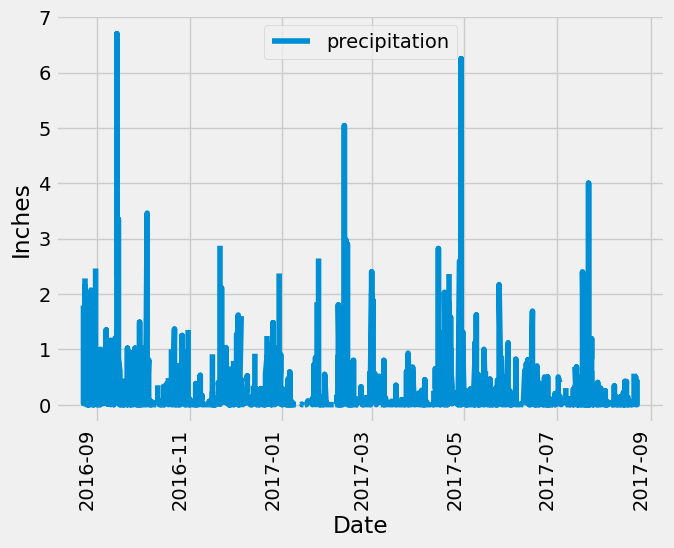

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(func.max(measurement.date)).first()[0]
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= func.date(recent_date, '-365 days')).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.set_index('date')['precipitation'].plot(figsize=(7, 6),rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'], loc='upper center')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
p_df = pd.DataFrame(df['precipitation'])
sum_stats = p_df.describe()
sum_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = [session.query(func.count(station.name)).first()]
total_stations


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs)). group_by(measurement.station).order_by(func.count().desc()).first()
[temperature_stats]


[(54.0, 85.0, 71.66378066378067)]

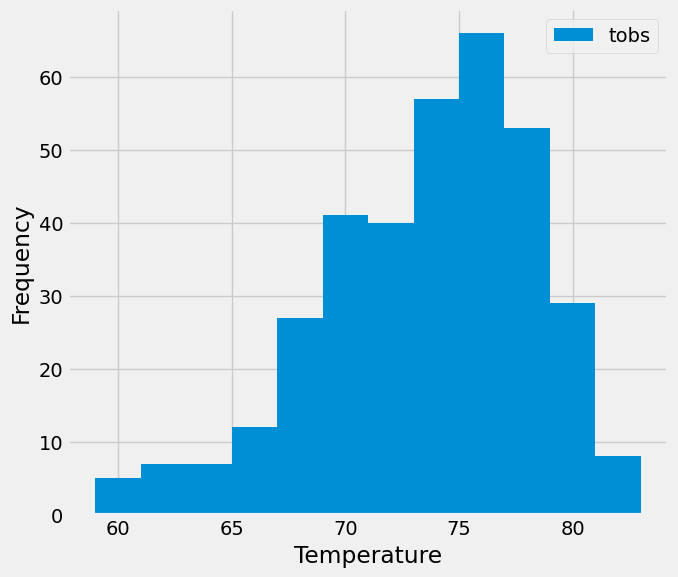

In [15]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

# Get the most recent date in the dataset
recent_date = session.query(func.max(measurement.date)).first()[0]

# Convert recent_date to a datetime object
recent_date_dt = pd.to_datetime(recent_date)

# Calculate the date one year ago from the most recent date in the dataset
one_year_ago = recent_date_dt - dt.timedelta(days=365)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')  # Convert to string

# Get the most active station ID
most_active_station_id = active_stations[0][0]

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(measurement.tobs).\
                    filter(measurement.station == most_active_station_id).\
                    filter(measurement.date >= one_year_ago_str).all()

# Create a DataFrame from the temperature data
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the results as a histogram
temperature_df.plot(kind='hist', bins=12, figsize=(7, 6))
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc='best')
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()